In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts

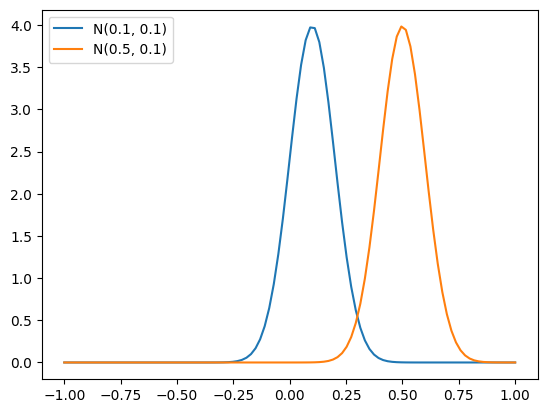

In [45]:
d_1 = sts.norm(0.1, 0.1)
d_2 = sts.norm(0.5, 0.1)
t = np.linspace(-1, 1, 100)

plt.plot(t, d_1.pdf(t), label=f'N{d_1.args}')
plt.plot(t, d_2.pdf(t), label=f'N{d_2.args}')
plt.legend(loc='upper left')
plt.savefig('../images/equal_var.png')

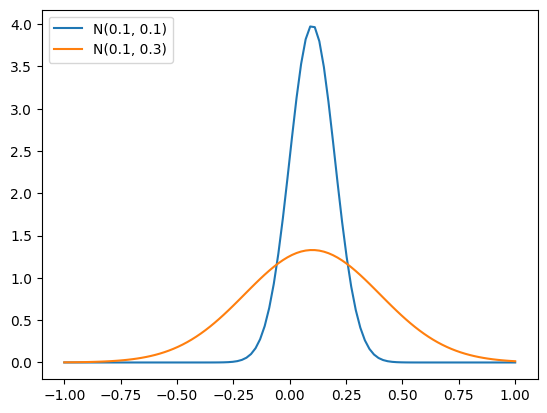

In [46]:
d_1 = sts.norm(0.1, 0.1)
d_2 = sts.norm(0.1, 0.3)
t = np.linspace(-1, 1, 100)

plt.plot(t, d_1.pdf(t), label=f'N{d_1.args}')
plt.plot(t, d_2.pdf(t), label=f'N{d_2.args}')
plt.legend(loc='upper left')
plt.savefig('../images/equal_mean.png')